<a href="https://colab.research.google.com/github/nekoradiation/National-Diet-Library/blob/master/KOKURITSU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 概要

# 1.   データの種類と評価方法

> 詳しくはHP参照（https://signate.jp/competitions/218）
*    資料画像に対して、予測対象のレイアウトラベルを含む矩形領域を、bounding box =(x1, y1, x2, y2) として割り当て、且つラベルの1つを付与。
*    各画像には、1つ以上の bounding boxが割り当てらる。
*    bounding box は画像の左上を原点（0,0）とし、オブジェクト領域の左上の座標（x1, y1）、右下の座標（x2, y2）の4つを指定することで表現される。
*    予測対象となるレイアウトラベルは、「古典籍資料」と「明治期以降刊行資料」で異なるため注意。

# 1.1 評価方法


> 評価対象（予測対象）となるレイアウトラベル
（ラベル名	説明）
*    1_overall	資料範囲全体
*    2_handwritten	くずし字の文字ライン
*    3_typography	くずし字以外の文字ライン
*    4_illustration	イラスト（写真含む）
*    5_stamp	印影（蔵書印等）
*    6_headline	見出し
*    7_caption	図表見出し
*    8_textline	6_headline, 7_caption 以外の文字ライン

> ※ラベル「9_table（表）」は、学習用データセットには含まれますが、評価対象（予測対象）からは外します。


# 1.1.1 評価関数
*    評価関数「mean IoU」を使用します。
*    評価値は0～1の値をとり、精度が高いほど大きな値となります。


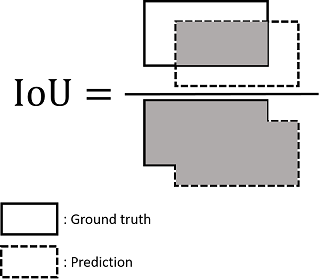

> 評価関数の詳細
*    ①全ラベルの予測領域と正解領域（矩形）の重なり（IoU）を計算
*    ②各画像に対して、ラベル毎の平均IoUを計算
*    ③各画像に対して、画像毎の平均IoU（②の平均値）を計算
*    ④評価対象の全画像の平均IoU（③の平均値）を計算





# 2.   今回とる手法

    *   手法A
    *   手法B
# 3.   どうしよっかな
# 4.   思いつかないな








# 前準備

In [1]:
#Driveへ接続
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# データの読み込み


